# Project  2 

In [193]:
import os
import numpy as np
import pickle
import torch
import pandas as pd

from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

Als eerste stap moeten we de gegenereerde data ophalen/inlezen:

In [194]:
#Sample data ophalen

sonar_samples = pd.read_table('../simpylc/samples/sonar_samples', sep = " ", header=None)

lidar_samples = pd.read_table('../simpylc/samples/lidar_samples', sep = " ", header=None)
lidar_samples_l = pd.read_table('../simpylc/samples/large_lidar_sample', sep = " ", header=None)


Vervolgens kijken we naar de afmetingen van de datasets - dit zegt namelijk ook direct iets over het aantal input neuronen in de input-laag van ons toekomstige neural net. 

In [195]:
print(f"Sonar data has shape {sonar_samples.shape}")
print(f"Lidar data has shape {lidar_samples.shape}")

Sonar data has shape (2993, 4)
Lidar data has shape (5664, 17)


Hoe zien de datasets er uit? We inspecteren zowel de eerste als laatste 5 rijen:

In [196]:
sonar_samples.head()

,0,1,2,3
0,1.4216,1.2448,1.7510,-22.0
1,1.4218,1.2450,1.7511,-22.0
2,1.4215,1.2448,1.7509,-22.0
3,1.4215,1.2448,1.7509,-22.0
4,1.4158,1.2402,1.7468,-22.0


In [197]:
sonar_samples.tail()

,0,1,2,3
2988,1.5485,1.7743,1.0869,22.0
2989,2.0917,1.1539,1.0575,0.0
2990,2.0632,1.1318,1.0445,0.0
2991,2.0632,1.1318,1.0445,0.0
2992,1.9847,1.6233,1.4057,0.0


Hierboven zien we de data van de Sonar versie van de auto - na ook de broncode van de simulatie te hebben bekeken is het duidelijk geworden dat deze auto 3 "sensoren" heeft die per t (tijdsinterval) de omgeving scannen op pionnen en de afstand tot deze objecten meten. Aan de hand van deze input wordt er een stuurhoek berekend (de laatste kolom), waarbij de auto zichzelf dus corrigeert aan de hand van omgevingsdata, zodat deze geen pionnen raakt en/of van de uitgezette track af gaat. 

Voor de lidar data geldt in principe hetzelfde, alleen zien we hier dat er in plaats van 3 sensoren gebruik wordt gemaakt van 16 sensoren. Ook zien we weer de berekende stuurhoek in de laatste kolom:

In [198]:
lidar_samples.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,7.4374,6.8442,8.3839,10.2577,12.9285,11.2363,5.7409,5.8726,20.0,20.0,5.2446,2.7496,4.3012,5.5170,1.4444,6.4318,-32.0
1,7.4374,6.8442,8.3839,10.2577,12.9285,11.2363,5.7409,5.8726,20.0,20.0,5.2446,2.7496,4.3012,5.5170,1.4444,6.4318,-32.0
2,7.4382,6.8450,8.3846,10.2585,12.9292,11.2370,5.7415,5.8731,20.0,20.0,5.2451,2.7502,4.3018,5.5177,1.4452,6.4326,-32.0
3,7.4382,6.8450,8.3846,10.2585,12.9292,11.2370,5.7415,5.8731,20.0,20.0,5.2451,2.7502,4.3018,5.5177,1.4452,6.4326,-32.0
4,7.4357,6.8427,8.3825,10.2565,12.9275,11.2355,5.7402,5.8722,20.0,20.0,5.2430,2.7479,4.2994,5.5152,1.4426,6.4300,-32.0


## De opdracht

Wat we in dit project uiteindelijk willen onderzoeken is het volgende: kunnen we met de bovenstaande data een neuraal netwerk trainen dat de juiste stuurhoek kan voorspellen aan de hand van de input, waarbij de "juiste stuurhoek" natuurlijk inhoudt dat de auto zichzelf, middels het neurale netwerk, netjes en veilig op de uitgezette baan houdt.

In [199]:
X_sonar = torch.Tensor(sonar_samples.iloc[:, :-1].to_numpy())
Y_sonar = torch.Tensor(sonar_samples.iloc[:, -1:].to_numpy())

X_lidar = torch.Tensor(lidar_samples_l.iloc[:, :-1].to_numpy())
Y_lidar = torch.Tensor(lidar_samples_l.iloc[:, -1:].to_numpy())

print(len(X_lidar))

19085


In [207]:
# Dataloader van de lidar dataset
loader = DataLoader(list(zip(X_lidar, Y_lidar)), shuffle=False, batch_size=10)

for X_batch, y_batch in loader:
    print(X_batch, y_batch)
    break

tensor([[ 7.4349,  6.8417,  8.3815, 10.2554, 12.9263, 11.2344,  5.7391,  5.8710,
         20.0000, 20.0000,  5.2431,  2.7478,  4.2993,  5.5149,  1.4421,  6.4294],
        [ 7.4349,  6.8417,  8.3815, 10.2554, 12.9263, 11.2344,  5.7391,  5.8710,
         20.0000, 20.0000,  5.2431,  2.7478,  4.2993,  5.5149,  1.4421,  6.4294],
        [ 7.4357,  6.8425,  8.3823, 10.2561, 12.9271, 11.2350,  5.7397,  5.8715,
         20.0000, 20.0000,  5.2436,  2.7484,  4.2999,  5.5156,  1.4429,  6.4302],
        [ 7.4357,  6.8425,  8.3823, 10.2561, 12.9271, 11.2350,  5.7397,  5.8715,
         20.0000, 20.0000,  5.2436,  2.7484,  4.2999,  5.5156,  1.4429,  6.4302],
        [ 7.4333,  6.8402,  8.3802, 10.2542, 12.9253, 11.2336,  5.7384,  5.8707,
         20.0000, 20.0000,  5.2415,  2.7462,  4.2975,  5.5131,  1.4403,  6.4277],
        [ 7.4333,  6.8402,  8.3802, 10.2542, 12.9253, 11.2336,  5.7384,  5.8707,
         20.0000, 20.0000,  5.2415,  2.7462,  4.2975,  5.5131,  1.4403,  6.4277],
        [ 7.4274,  6.8

In [208]:
device = (

"cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

print(f"Using {device} device")

Using mps device


In [209]:
class lidar_sweep_2(nn.Module):

    def __init__(self, inputs_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, outputs_size):
        super().__init__()

        self.model = nn.Sequential(
                nn.Linear(inputs_size, hidden1_size),
                nn.ReLU(),
                nn.Linear(hidden1_size, hidden2_size),
                nn.ReLU(),
                nn.Linear(hidden2_size, hidden3_size),
                nn.ReLU(),
                nn.Linear(hidden3_size, hidden4_size),
                nn.ReLU(),
                nn.Linear(hidden4_size, outputs_size),
                                    )
        
    def forward(self, x):
        
        return self.model(x)

In [210]:
# model_1 = lidar_sweep_2(16, 64, 64, 128, 1)


# learning_rate = 0.000075

# loss_function = nn.MSELoss()
# gradientDescent = torch.optim.SGD(model_1.parameters(), lr=learning_rate)

In [241]:
model_1 = lidar_sweep_2(16, 100, 75, 50, 25, 1)


learning_rate = 0.00005

loss_function = nn.MSELoss()
gradientDescent = torch.optim.SGD(model_1.parameters(), lr=learning_rate)

epochs = 500
losses = []

model_1.train()

for i in tqdm(range(epochs)):
    
    epoch_loss = []
    
    for x_batch, y_batch in loader:
        
        gradientDescent.zero_grad()
        
        y_pred = model_1(x_batch)
        
        loss = loss_function(y_pred, y_batch)
    
        loss.backward()
        
        gradientDescent.step()
        
        epoch_loss.append(loss.item())
        
        
    losses.append(sum(epoch_loss) / len(loader))

#losses = [loss.detach().numpy() for loss in losses]
        

100%|█████████████████████████████████████████| 500/500 [03:34<00:00,  2.33it/s]


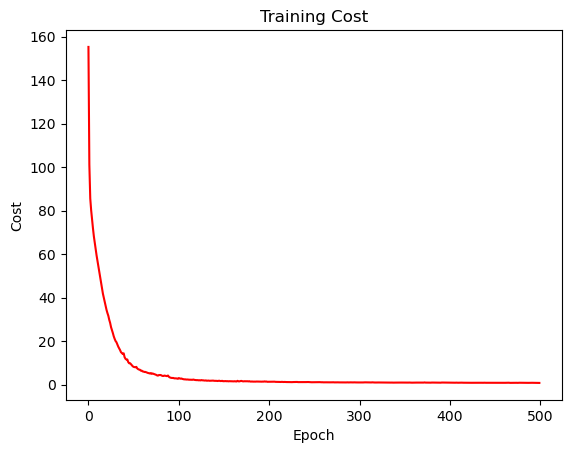

In [242]:
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(len(losses))], losses, 'red')
plt.show()

In [244]:
print(losses)

[155.28316815590878, 101.14217767344994, 85.60621598068256, 80.19566894960363, 75.96806432417412, 71.86276059230471, 68.16890528064754, 65.13275974327401, 62.24432142855743, 59.409864339866274, 56.85546811546051, 54.105845094000315, 51.608240818441885, 48.889046902694645, 46.3841726142677, 44.102391384452226, 41.8371350874294, 39.86571593076037, 38.116074636057526, 36.2497840429485, 34.39283181897293, 32.92497904381128, 31.67169977691768, 29.82958214823498, 28.406208458745382, 26.44735585648182, 25.117015576654545, 23.74578431150898, 22.227516147655894, 21.063556955572103, 20.067860108300177, 19.508178519938802, 18.527393988866873, 17.46701318741961, 16.726355471277625, 15.891086744920255, 14.935827246834434, 14.543676682792295, 14.103856128218474, 14.401258792113483, 12.645148829351614, 11.885386971176263, 11.562973526050325, 11.583155669176326, 10.412297992641667, 9.851692934803014, 9.890951276147486, 9.440442415223602, 8.91066110155249, 8.455093035572967, 8.174309858096096, 8.087156

In [245]:
pickle.dump(model_1.model, open('model_1.pkl', 'wb'))

In [246]:
model_1.eval()
y_pred = model_1(X_lidar)
acc = (y_pred.round() == Y_lidar).float().mean()
acc = float(acc)
print("Model accuracy: %.2f%%" % (acc*100))

Model accuracy: 25.94%
